The following is an example of a positive enhancer sequence and a background sequence from the human genome.

In [3]:
bp_lengths = []
for i in range(61936):
    with open(f'human_enhancers_ensembl/train/positive/{i}.txt', 'r') as f_positive:
        for l in f_positive.readlines():
            bp_lengths.append(len(l))

for i in range(61936):
    with open('human_enhancers_ensembl/train/negative/2.txt') as f_negative:
        for l in f_negative.readlines():
            bp_lengths.append(len(l))

print('Max sequence length: ', max(bp_lengths))

Max sequence length:  573


### dna2vec k-mer encoder
This is one of the k-mer encoders that will be used on the input sequences

In [2]:
from gensim.models import KeyedVectors
import numpy as np

filepath = "dna2vec/pretrained/dna2vec-20161219-0153-k3to8-100d-10c-29320Mbp-sliding-Xat.w2v"

# These pretrained dna2vec files are in text word2vec format → binary=False
kv = KeyedVectors.load_word2vec_format(filepath, binary=False)

def vector(kmer: str):
    return kv[kmer]

def cosine_distance(a: str, b: str) -> float:
    # gensim gives cosine *similarity*, so distance = 1 - similarity
    return 1.0 - kv.similarity(a, b)

if __name__ == "__main__":
    print("AGCA vec:", vector("AGCA"))
    print("cosdist(AAA, GCT)  :", cosine_distance("AAA", "GCT"))
    print("cosdist(AAA, AAAA) :", cosine_distance("AAA", "AAAA"))


AGCA vec: [ 0.031934  0.440418 -0.150419  0.014716  0.119263  0.058114 -0.312005
 -0.161748 -0.349029 -0.266925  0.327924  0.058812  0.325346  0.555622
 -0.342733  0.174307  0.102776  0.135182 -0.391096 -0.116741  0.206415
 -0.28563   0.088689  0.040088 -0.027641 -0.275357 -0.14471   0.263251
  0.047554 -0.036737  0.364251 -0.116972  0.286012  0.103939 -0.00627
 -0.327004 -0.344822  0.100827 -0.284543  0.271215  0.070308  0.332634
  0.067491 -0.066082 -0.4517    0.00998  -0.48495   0.259643 -0.25499
 -0.117224 -0.292354 -0.142832  0.045673 -0.113715 -0.298148 -0.036117
 -0.082101  0.247983 -0.183166 -0.098923  0.641029  0.221092 -0.012978
  0.352521  0.554256  0.174414 -0.083894  0.358389  0.096209 -0.169332
 -0.18865   0.161321 -0.256877 -0.003476 -0.223552  0.038645 -0.307966
  0.373101  0.032724  0.271275 -0.099642  0.190561 -0.16275  -0.058928
 -0.348395  0.078296 -0.605732 -0.167607  0.028524  0.061146 -0.149679
  0.041624 -0.398863 -0.494398  0.326998 -0.088775  0.179929  0.22495

### Creating PyTorch training file

In [ ]:
import torch
import numpy as np

sequences = []
labels = []
for i in range(61936):
    with open(f'human_enhancers_ensembl/train/positive/{i}.txt', 'r') as f_positive:
        for l in f_positive.readlines():
            sequences.append(l)
            labels.append(1)
            lengths.append('')

for i in range(61936):
    with open(f'human_enhancers_ensembl/train/negative/{i}.txt', 'r') as f_negative:
        for l in f_negative.readlines():
            sequences.append(l)
            labels.append(0)

torch.save({"seqs": sequences, "labels": labels}, "train_raw.pt")


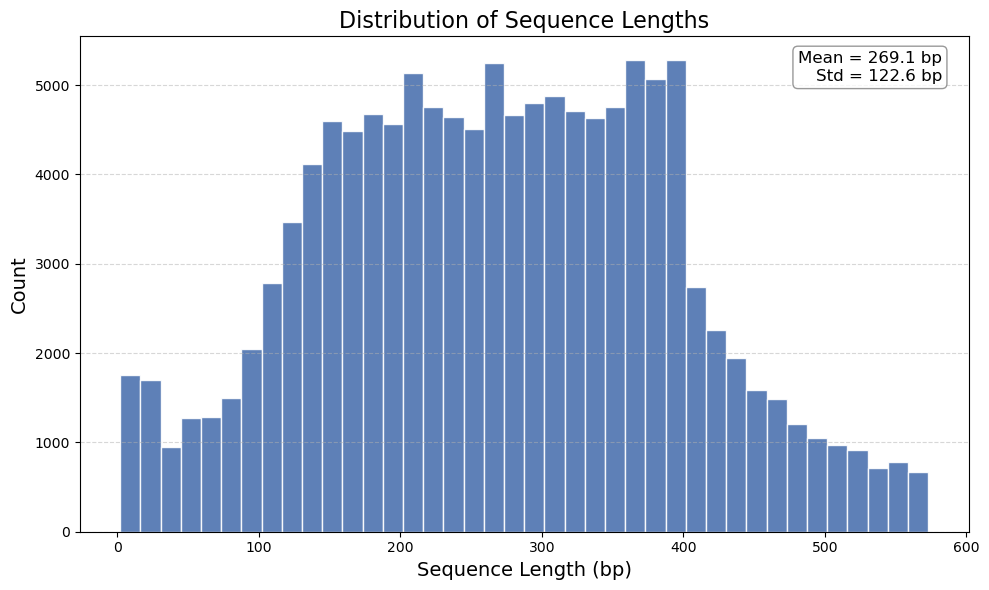

Mean length: 269.11
Std: 122.62
Percent <=400 bp: 0.865
Percent <=300 bp: 0.586
Percent <=200 bp: 0.314
Percent <=100 bp: 0.083


In [15]:
import numpy as np
import matplotlib.pyplot as plt

lengths = np.array([len(s) for s in sequences])

# Percentages
lt_400 = np.sum(lengths <= 400) / len(lengths)
lt_300 = np.sum(lengths <= 300) / len(lengths)
lt_200 = np.sum(lengths <= 200) / len(lengths)
lt_100 = np.sum(lengths <= 100) / len(lengths)

mean_len = lengths.mean()
std_len = lengths.std()

plt.figure(figsize=(10, 6))

plt.hist(
    lengths,
    bins=40,                    # good balance between detail + noise
    color="#4C72B0",            # seaborn-ish blue
    edgecolor="white",          # crisp visual
    alpha=0.9
)

plt.title("Distribution of Sequence Lengths", fontsize=16)
plt.xlabel("Sequence Length (bp)", fontsize=14)
plt.ylabel("Count", fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.5)

# Text box with mean + std
textstr = f"Mean = {mean_len:.1f} bp\nStd = {std_len:.1f} bp"
plt.text(
    0.97, 0.97, textstr,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

plt.tight_layout()
plt.savefig('training_data_distribution.png', dpi=250)
plt.show()

print(f"Mean length: {mean_len:.2f}")
print(f"Std: {std_len:.2f}")
print(f"Percent <=400 bp: {lt_400:.3f}")
print(f"Percent <=300 bp: {lt_300:.3f}")
print(f"Percent <=200 bp: {lt_200:.3f}")
print(f"Percent <=100 bp: {lt_100:.3f}")
